Shape (lat, lon) = (512, 1024)
Min, max values = -727.4596 580.19275


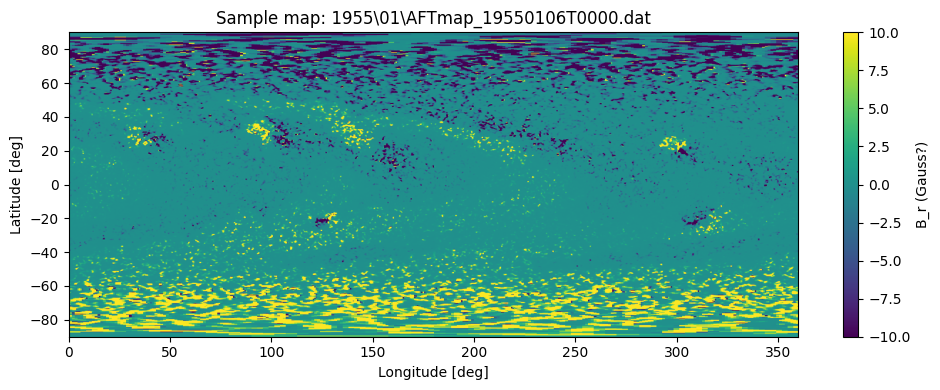

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def read_IDLdat(filepath):
    data = np.fromfile(filepath, dtype=np.float32).reshape(512, -1)
    return data

# CHANGE to your actual path
filepath = "1955\\01\\AFTmap_19550106T0000.dat"

# Load the file
map01 = read_IDLdat(filepath)
print("Shape (lat, lon) =", map01.shape)
print("Min, max values =", np.nanmin(map01), np.nanmax(map01))

# Latitude and longitude arrays (guessing orientation for now)
nlat, nlon = map01.shape
lat = np.linspace(90, -90, nlat)   # 512 points from north to south
lon = np.linspace(0, 360, nlon, endpoint=False)

# Quick visualization
plt.figure(figsize=(10,4))
plt.imshow(map01, origin='upper',
           extent=[lon.min(), lon.max(), lat.min(), lat.max()],
           aspect='auto', 
           vmin=-10, vmax=10)
plt.colorbar(label='B_r (Gauss?)')
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.title('Sample map: ' + filepath)
plt.tight_layout()
plt.show()


In [ ]:
import os
from glob import glob
from datetime import datetime

def read_IDLdat(filepath):
    return np.fromfile(filepath, dtype=np.float32).reshape(512, -1)

# CHANGE this to your actual 1955 root folder
root_folder = "1955"

# Collect all .dat files in subfolders
filelist = sorted(glob(os.path.join(root_folder, "**", "*.dat"), recursive=True))
print("Found", len(filelist), "files")

maps = []
dates = []
for f in filelist:
    m = read_IDLdat(f)
    maps.append(m)

    # extract YYYYMMDD from filename
    fname = os.path.basename(f)
    import re
    mo = re.search(r"(\d{8})", fname)
    if mo:
        dates.append(datetime.strptime(mo.group(1), "%Y%m%d"))
    else:
        dates.append(None)

maps = np.stack(maps, axis=0)
print("maps shape =", maps.shape)
print("First 5 dates =", dates[:5])
print("Last 5 dates  =", dates[-5:])


Found 365 files
maps shape = (365, 512, 1024)
First 5 dates = [datetime.datetime(1955, 1, 1, 0, 0), datetime.datetime(1955, 1, 2, 0, 0), datetime.datetime(1955, 1, 3, 0, 0), datetime.datetime(1955, 1, 4, 0, 0), datetime.datetime(1955, 1, 5, 0, 0)]
Last 5 dates  = [datetime.datetime(1955, 12, 27, 0, 0), datetime.datetime(1955, 12, 28, 0, 0), datetime.datetime(1955, 12, 29, 0, 0), datetime.datetime(1955, 12, 30, 0, 0), datetime.datetime(1955, 12, 31, 0, 0)]


maps_avg shape: (365, 512, 1024)


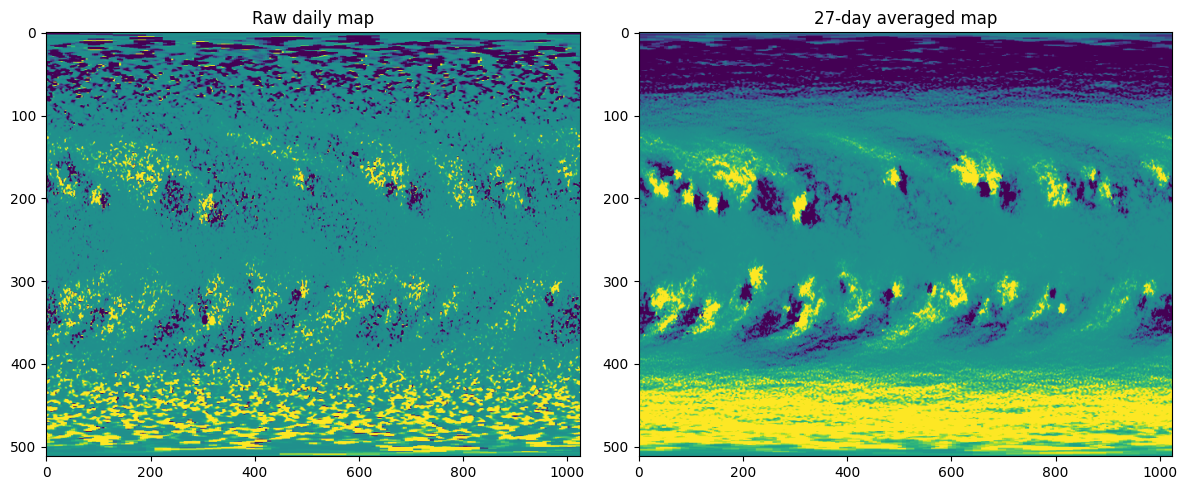

In [ ]:
import numpy as np

def running_mean_maps(maps, window_days=27):
    
    # Compute running-mean maps with given window size.
    # maps: (ntime, nlat, nlon)
    # returns: maps_avg (ntime, nlat, nlon)
    
    ntime = maps.shape[0]
    half = window_days // 2
    maps_avg = []
    for i in range(ntime):
        i0 = max(0, i - half)
        i1 = min(ntime, i + half + 1)
        window = maps[i0:i1].mean(axis=0)
        maps_avg.append(window)
    return np.stack(maps_avg, axis=0)

maps_avg = running_mean_maps(maps, window_days=27)
print("maps_avg shape:", maps_avg.shape)

# Quick check: compare raw vs averaged map for mid-year
import matplotlib.pyplot as plt
i_mid = 180
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(maps[i_mid], origin='upper', aspect='auto', vmin=-10, vmax=10)
plt.title("Raw daily map")
plt.subplot(1,2,2)
plt.imshow(maps_avg[i_mid], origin='upper', aspect='auto', vmin=-10, vmax=10)
plt.title("27-day averaged map")
plt.tight_layout()
plt.show()


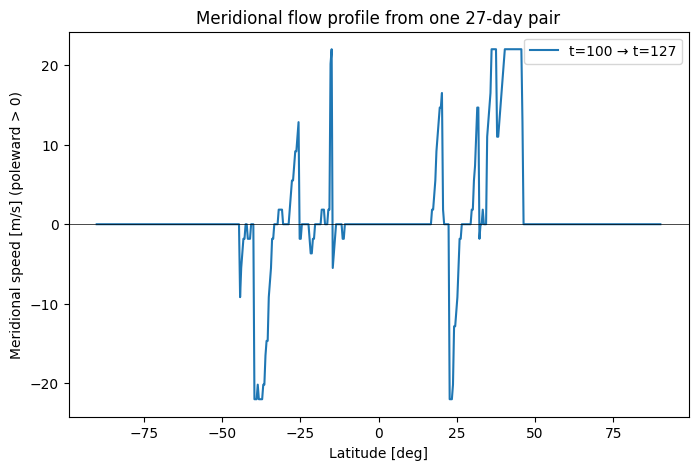

Example speeds (m/s) at a few lats:
lat=-0.2°, u≈-0.00
lat=15.0°, u≈-0.00
lat=30.1°, u≈1.83
lat=44.9°, u≈22.00


In [ ]:
import numpy as np

R_sun = 6.957e8  # [m], solar radius

def lat_shift_between_maps(mapA, mapB, max_shift_pix=10, lat_bin_halfwidth=2):

    # Cross-correlate latitude strips between two maps.
    # Returns array of latitudinal shifts (in pixels) for each latitude index.

    nlat, nlon = mapA.shape
    delta_pix = np.full(nlat, np.nan)
    for i_lat in range(nlat):
        i0 = max(0, i_lat - lat_bin_halfwidth)
        i1 = min(nlat, i_lat + lat_bin_halfwidth + 1)
        stripA = mapA[i0:i1, :].ravel()
        if np.all(stripA == 0):
            continue
        corrs = []
        shifts = np.arange(-max_shift_pix, max_shift_pix+1)
        for s in shifts:
            rolled = np.roll(mapB, s, axis=0)
            if s > 0:
                rolled[:s, :] = 0
            elif s < 0:
                rolled[s:, :] = 0
            stripB = rolled[i0:i1, :].ravel()
            if np.std(stripA)==0 or np.std(stripB)==0:
                corrs.append(-1e9)
            else:
                corrs.append(np.corrcoef(stripA, stripB)[0,1])
        corrs = np.array(corrs)
        imax = np.argmax(corrs)
        best_shift = shifts[imax]
        delta_pix[i_lat] = best_shift
    return delta_pix

def pixels_to_speed(delta_pix, lat_array, delta_t_days):
    # Convert pixel shift to m/s
    deg_per_pix = lat_array[1] - lat_array[0]
    delta_deg = delta_pix * deg_per_pix
    delta_rad = np.deg2rad(delta_deg)
    delta_t_sec = delta_t_days * 86400.0
    u = R_sun * delta_rad / delta_t_sec
    return u

# Latitude array
nlat, nlon = maps_avg.shape[1:]
lat = np.linspace(90, -90, nlat)

# Pick two maps separated by 27 days
t0 = 100     # around early April 1955
lag = 27
mapA = maps_avg[t0]
mapB = maps_avg[t0 + lag]

# Measure shifts and convert to speed
delta_pix = lat_shift_between_maps(mapA, mapB, max_shift_pix=12, lat_bin_halfwidth=2)
u_profile = pixels_to_speed(delta_pix, lat, delta_t_days=lag)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(lat, u_profile, label=f"t={t0} → t={t0+lag}")
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("Latitude [deg]")
plt.ylabel("Meridional speed [m/s] (poleward > 0)")
plt.title("Meridional flow profile from one 27-day pair")
plt.legend()
plt.show()

print("Example speeds (m/s) at a few lats:")
for L in [0, 15, 30, 45]:
    idx = np.argmin(np.abs(lat - L))
    print(f"lat={lat[idx]:.1f}°, u≈{u_profile[idx]:.2f}")


100%|██████████| 338/338 [49:04<00:00,  8.71s/it]


Fit parameters: A=3.64±0.18, B=0.49±0.18 [m/s]


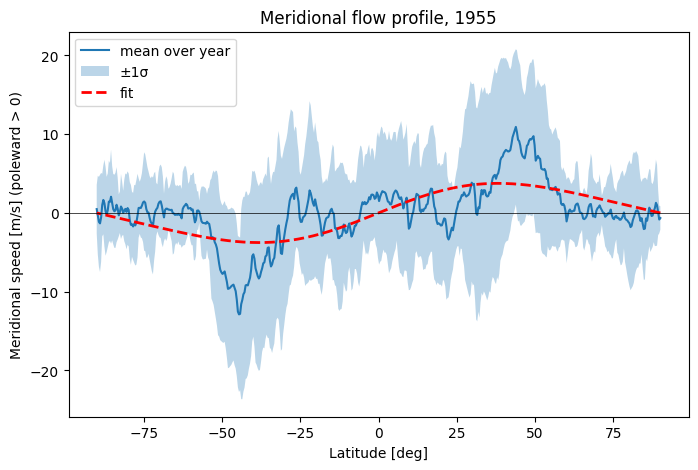

In [ ]:
from tqdm import tqdm
from scipy.optimize import curve_fit

lag = 27
ntime = maps_avg.shape[0]

all_profiles = []
for t in tqdm(range(0, ntime - lag)):
    A = maps_avg[t]
    B = maps_avg[t + lag]
    delta_pix = lat_shift_between_maps(A, B, max_shift_pix=12, lat_bin_halfwidth=2)
    u = pixels_to_speed(delta_pix, lat, delta_t_days=lag)
    all_profiles.append(u)

all_profiles = np.stack(all_profiles, axis=0)  # (Npairs, Nlat)
u_mean = np.nanmean(all_profiles, axis=0)
u_std  = np.nanstd(all_profiles, axis=0)

# Fit an analytic model
lat_rad = np.deg2rad(lat)

def merid_model(lat_rad, A, B):
    # Simple symmetric model: A*sin(2λ) + B*sin(4λ)
    return A*np.sin(2*lat_rad) + B*np.sin(4*lat_rad)

mask = np.isfinite(u_mean)
popt, pcov = curve_fit(merid_model, lat_rad[mask], u_mean[mask], p0=[15,-5])
A_fit, B_fit = popt
perr = np.sqrt(np.diag(pcov))

print(f"Fit parameters: A={A_fit:.2f}±{perr[0]:.2f}, B={B_fit:.2f}±{perr[1]:.2f} [m/s]")

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(lat, u_mean, label="mean over year")
plt.fill_between(lat, u_mean-u_std, u_mean+u_std, alpha=0.3, label="±1σ")
plt.plot(lat, merid_model(lat_rad, *popt), 'r--', lw=2, label="fit")
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("Latitude [deg]")
plt.ylabel("Meridional speed [m/s] (poleward > 0)")
plt.title("Meridional flow profile, 1955")
plt.legend()
plt.show()
